Average Interval Width: 0.914
Standard Deviation of Predictions: 0.028
Coverage Probability: 0.267
Entropy: 0.455


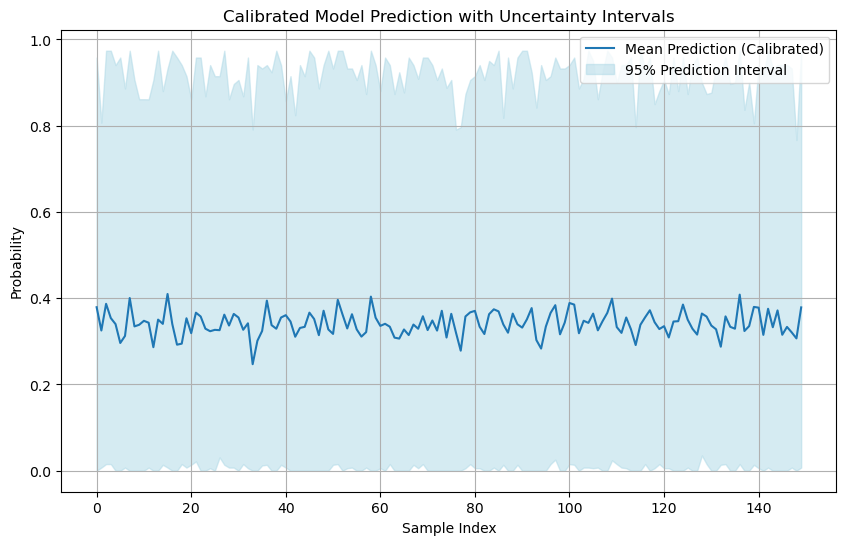

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, PandasTools, AllChem, DataStructs, rdFingerprintGenerator
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, log_loss, roc_curve
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.utils import resample

# Load SDF file and convert to DataFrame using a raw string for the path
sdf_file = "Structures_759_training.sdf"  
sdf_supplier = Chem.SDMolSupplier(sdf_file)
df = PandasTools.LoadSDF(sdf_file, smilesName='SMILES', molColName='Molecule', includeFingerprints=False)

# List of selected descriptors
selected_columns = [
    'r_qp_mol_MW', 'r_qp_volume', 'r_qp_SASA', 'r_qp_PSA',
    'r_qp_QPlogS', 'r_qp_CIQPlogS', 'r_qp_QPlogPoct', 'r_qp_QPlogPo/w',
    'r_qp_dipole', 'r_qp_donorHB', 'r_qp_accptHB',
    'r_qp_QPPCaco', 'r_qp_QPlogBB', 'i_qp_HumanOralAbsorption',
    'r_qp_PercentHumanOralAbsorption', 'r_qp_QPlogHERG',
    'r_qp_IP(eV)', 'r_qp_EA(eV)',
    'i_qp_#stars', 'i_qp_#rotor', 'i_qp_RuleOfFive', 'i_qp_RuleOfThree', 'i_qp_#NandO'
]

# Calculate the molecular fingerprint fcfp_6 and expand it into multiple columns
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=6)
def calculate_fcfp6(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fcfp6 = morgan_gen.GetFingerprint(mol)
    array = np.zeros((1,), dtype=int)
    DataStructs.ConvertToNumpyArray(fcfp6, array)
    return array

# Generate Morgan fingerprints and convert to DataFrame
fcfp6_data = df['SMILES'].apply(calculate_fcfp6)
fcfp6_df = pd.DataFrame(fcfp6_data.tolist(), index=df.index)

# Concatenate original features with Morgan fingerprints
features = df[selected_columns].join(fcfp6_df).dropna()

# Extract the target variable 'Stable'
target_column = 'Stable'
labels = df[target_column].loc[features.index]
labels = labels.astype(int)  # Ensure labels are integers

# Standardizing the descriptor features
scaler = StandardScaler()
scaled_descriptors = scaler.fit_transform(features[selected_columns])

# Apply PCA to scaled descriptor features
pca = PCA(n_components=9)  # Adjust the number of components if needed
principal_components = pca.fit_transform(scaled_descriptors)

# Combine PCA transformed descriptors with original Morgan fingerprints
combined_features = np.hstack((principal_components, fcfp6_df.loc[features.index].values))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    combined_features, labels, test_size=0.2, random_state=42
)

# Random Forest Model with Hyperparameter Optimization (Tuning)
param_dist = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=100,
                                   cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
best_rf_model = random_search.best_estimator_
calibrated_rf_model = CalibratedClassifierCV(best_rf_model, method='isotonic', cv=5)
calibrated_rf_model.fit(X_train, y_train)

# Function to calculate uncertainty intervals
def simulate_with_uncertainty(model, X, n_iterations=100, percentile=95):
    simulations = []
    for _ in range(n_iterations):
        # Resample the data
        X_resampled = resample(X)
        # Predict probabilities
        sim_pred_probs = model.predict_proba(X_resampled)[:, 1]
        simulations.append(sim_pred_probs)
  
    simulations = np.array(simulations)
    mean_prediction = np.mean(simulations, axis=0)
    lower_bound = np.percentile(simulations, (100 - percentile) / 2.0, axis=0)
    upper_bound = np.percentile(simulations, 100 - (100 - percentile) / 2.0, axis=0)
  
    return mean_prediction, lower_bound, upper_bound

# Calculate uncertainty using the simulation function
mean_pred_calib, lower_calib, upper_calib = simulate_with_uncertainty(calibrated_rf_model, X_test)

# Quantitative metrics on uncertainty
# 1. Average Interval Width
interval_widths = upper_calib - lower_calib
average_interval_width = np.mean(interval_widths)
print(f"Average Interval Width: {average_interval_width:.3f}")

# 2. Standard Deviation of Predictions
std_dev = np.std(mean_pred_calib)
print(f"Standard Deviation of Predictions: {std_dev:.3f}")

# 3. Coverage Probability
coverage_prob = np.mean((y_test >= lower_calib) & (y_test <= upper_calib))
print(f"Coverage Probability: {coverage_prob:.3f}")

# 4. Entropy of Predictions
y_prob_calibrated = calibrated_rf_model.predict_proba(X_test)[:, 1]
epsilon = 1e-9  # Small value to prevent log(0)
entropy = -np.mean(y_prob_calibrated * np.log(y_prob_calibrated + epsilon) + (1 - y_prob_calibrated) * np.log(1 - y_prob_calibrated + epsilon))
print(f"Entropy: {entropy:.3f}")

# Plotting the uncertainty intervals
plt.figure(figsize=(10, 6))
plt.plot(mean_pred_calib, label='Mean Prediction (Calibrated)')
plt.fill_between(range(len(mean_pred_calib)), lower_calib, upper_calib, color='lightblue', alpha=0.5, label='95% Prediction Interval')
plt.title('Calibrated Model Prediction with Uncertainty Intervals')
plt.xlabel('Sample Index')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()